In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input, GlobalAveragePooling2D, Concatenate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, roc_curve

In [3]:
# Load dataset
df = pd.read_csv('D:/Mini Project/new project/archive/data.csv')  # Adjust path as needed
df.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)

In [5]:
# Label encoding: B -> 0 (benign), M -> 1 (malignant)
df['diagnosis'] = df['diagnosis'].map({'B': 0, 'M': 1})

In [7]:
# Splitting data into features (X) and labels (y)
X = df.drop('diagnosis', axis=1).values
y = df['diagnosis'].values

In [9]:
# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
# Reshape input to fit image-based model expectations (reshaping 30 features into 5x6 'image')
X_train = X_train.reshape(-1, 5, 6, 1)
X_test = X_test.reshape(-1, 5, 6, 1)

In [15]:
### 1. **Building a Custom CNN Model**:
cnn_input = Input(shape=(5, 6, 1))
x = Conv2D(32, (3, 3), activation='relu')(cnn_input)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
cnn_output = Dense(128, activation='relu')(x)

In [17]:
### 2. **Building the AlexNet-inspired Model with LeakyReLU**:
alexnet_input = Input(shape=(5, 6, 1))
y = Conv2D(96, (2, 2), strides=(1, 1))(alexnet_input)
y = LeakyReLU(negative_slope=0.01)(y)  # LeakyReLU with small negative slope (alpha=0.01)
y = MaxPooling2D(pool_size=(2, 2))(y)
y = Conv2D(256, (2, 2))(y)
y = LeakyReLU(negative_slope=0.01)(y)  # LeakyReLU applied again
y = Flatten()(y)
alexnet_output = Dense(1024)(y)
alexnet_output = LeakyReLU(negative_slope=0.01)(alexnet_output)  # LeakyReLU for the Dense layer

In [19]:
### 3. **Integrating Custom CNN with AlexNet**:
# Concatenating the outputs from both models
combined = Concatenate()([cnn_output, alexnet_output])

In [21]:
# Adding a fully connected layer
combined_output = Dense(512, activation='relu')(combined)

In [23]:
# Final output layer (binary classification)
final_output = Dense(1, activation='sigmoid')(combined_output)

In [25]:
# Building the final model
model = Model(inputs=[cnn_input, alexnet_input], outputs=final_output)

In [27]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 5, 6, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 4, 5, 96)  │        480 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 4, 5, 96)  │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 2, 2, 96)  │          0 │ leaky_re_lu[0][0] │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 5, 6, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 1, 1, 256) │     98,560 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 3, 4, 32)  │        320 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 1, 1, 256) │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 1, 2, 32)  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 256)       │          0 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 64)        │          0 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1024)      │    263,168 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      8,320 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 1024)      │          0 │ dense_1[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1152)      │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    590,336 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        513 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 961,697 (3.67 MB)

 Trainable params: 961,697 (3.67 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
### 4. **Train the Model**:
history = model.fit([X_train, X_train], y_train, 
                    validation_data=([X_test, X_test], y_test), 
                    epochs=20,  # Adjust the number of epochs as needed
                    batch_size=32)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9561 - val_loss: 0.1406
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9474 - val_loss: 0.1592
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9984 - loss: 0.0017 - val_accuracy: 0.9474 - val_loss: 0.1979
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9987 - loss: 0.0025 - val_accuracy: 0.9649 - val_loss: 0.1764
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9960 - loss: 0.0106 - val_accuracy: 0.9737 - val_loss: 0.2179
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9888 - loss: 0.0455 - val_accuracy: 0.9649 - val_loss: 0.0953
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0166 - val_accuracy: 0.9649 - val_loss: 0.0753
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9923 - loss: 0.0100 - val_accuracy: 0.9474 - v

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Accuracy: 0.956140350877193
              precision    recall  f1-score   support

           0       0.97      0.96      0.96        71
           1       0.93      0.95      0.94        43

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



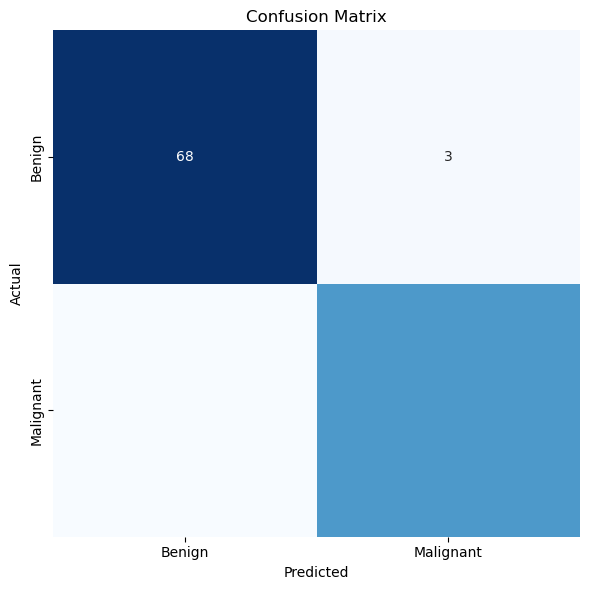

In [47]:
### 5. **Evaluate the Model**:
def evaluate_model(model, X_test, y_test):
    # Predict the model on test data
    predictions = model.predict([X_test, X_test])
    predictions = (predictions > 0.5).astype(int)  # Convert probabilities to binary output
    
    # Compute accuracy
    acc = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)
    
    print(f"Accuracy: {acc}")
    print(report)
    
        # Plot Confusion Matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
                xticklabels=['Benign', 'Malignant'], 
                yticklabels=['Benign', 'Malignant'], 
                cbar=False)  # Disable the color bar to focus on values
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.tight_layout()  # Ensures the layout doesn't overlap
    plt.show()

    return acc

# Evaluate the model and plot confusion matrix
acc = evaluate_model(model, X_test, y_test)

In [49]:
### 6. **Plotting Accuracy, Precision, Recall Curves**:
def plot_metrics(history):
    # Plot Accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

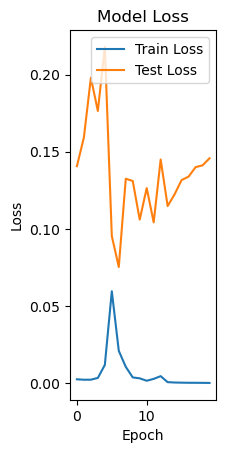

In [51]:
# Plot Loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


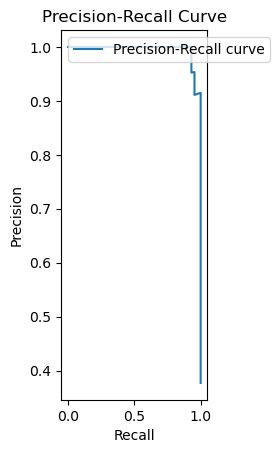

In [53]:
# Precision-Recall curve
plt.subplot(1, 3, 3)
precision, recall, _ = precision_recall_curve(y_test, model.predict([X_test, X_test]))
plt.plot(recall, precision, label='Precision-Recall curve')
plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc='upper left')
plt.show()

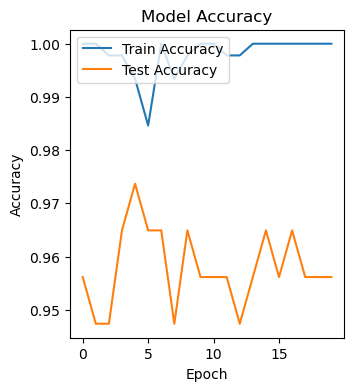

In [55]:
# Plot the accuracy, loss and precision-recall curve
plot_metrics(history)

In [43]:
### 7. **Prediction Example**:
def make_prediction(model, sample):
    # Reshape and scale the sample if necessary
    sample = scaler.transform(sample.reshape(1, -1))  # Scale like training data
    sample = sample.reshape(1, 5, 6, 1)  # Reshape like the training data
    prediction = model.predict([sample, sample])
    return 'Malignant' if prediction > 0.5 else 'Benign'

In [45]:
# Example of predicting with one test sample
new_sample = np.array([19.81, 22.15, 130, 1260, 0.09831, 0.1027, 0.1479, 0.09498, 0.1582, 0.05395, 0.7582, 1.017, 5.865,
                       112.4, 0.006494, 0.01893, 0.03391, 0.01521, 0.01356, 0.001997, 27.32, 30.88, 186.8, 2398, 0.1512, 
                       0.315, 0.5372, 0.2388, 0.2768, 0.07615])
sample = new_sample
print(make_prediction(model, sample))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Malignant
